In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

ROOT_DIR = os.path.abspath(".")

sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import visualize

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
IMG_DIM = 256

In [3]:
class CraterConfig(Config):
    BACKBONE = "resnet50"

    NAME = f"craters_{IMG_DIM}"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 2

    IMAGE_MIN_DIM = IMG_DIM

    IMAGE_MAX_DIM = IMG_DIM

    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)

    USE_MINI_MASK = False

    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 50


config = CraterConfig()


config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [4]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [5]:
class CraterDataset(utils.Dataset):
    def __init__(self):
        super().__init__()
        self.label_encoder = LabelEncoder()
        self.train_labels_encoded = self.label_encoder.fit_transform(np.arange(1, 3))
        self.one_hot_encoder = OneHotEncoder(sparse_output=False).fit(
            self.train_labels_encoded.reshape(-1, 1)
        )

    def load_images(self, dataset_dir):
        self.add_class("craters", 1, "crater")

        images = glob.glob(os.path.join(dataset_dir, "*.tif"))
        for i, path in enumerate(images):
            self.add_image(
                "craters",
                image_id=i,
                path=path,
                width=IMG_DIM,
                height=IMG_DIM,
            )

    def load_image(self, image_id):
        image_path = self.image_info[image_id]["path"]
        image = tiff.imread(image_path).astype(np.float32)
        image = 255 * (image - image.min()) / (image.max() - image.min())
        # remove alpha channel
        if image.shape[-1] == 4:
            image = image[:, :, :3]

        return image

    def image_reference(self, image_id):
        pass

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        image_name = info["path"].split("/")[-1].split("\\")[-1]
        image_id_in_path = image_name.split("_")[0]
        mask_path = os.path.join(
            f"../../dataset/label_data_{IMG_DIM}", f"{image_id_in_path}_mask.tif"
        )
        mask = tiff.imread(mask_path).astype(np.float32)
        mask = (
            self.one_hot_encoder.transform(mask.flatten().reshape(-1, 1))
            .reshape(IMG_DIM, IMG_DIM, 2)
            .astype(np.uint8)
        )

        return mask, np.array([0, 1])

In [6]:
dataset_train = CraterDataset()
dataset_train.load_images(f"../../dataset/data_train_{IMG_DIM}")
dataset_train.prepare()

dataset_val = CraterDataset()
dataset_val.load_images(f"../../dataset/data_validate_{IMG_DIM}")
dataset_val.prepare()

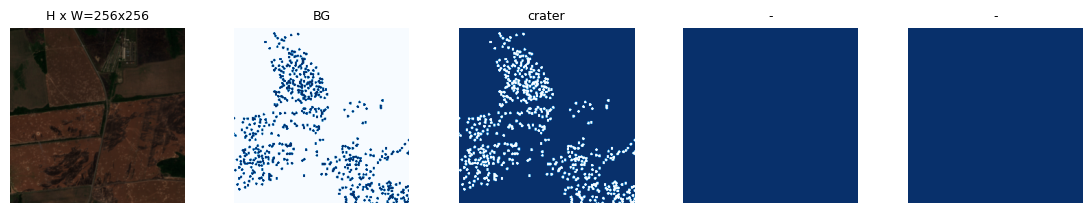

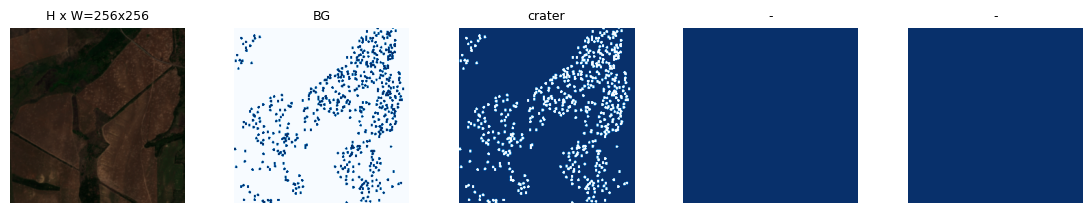

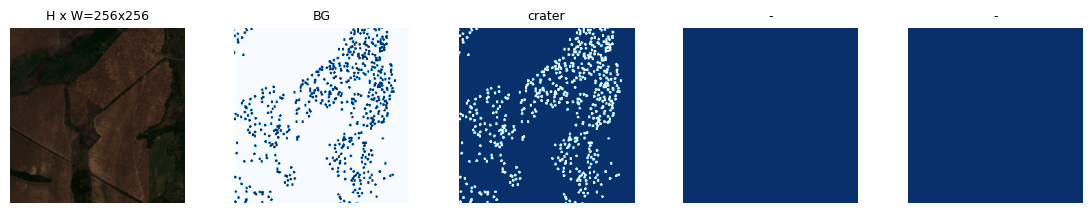

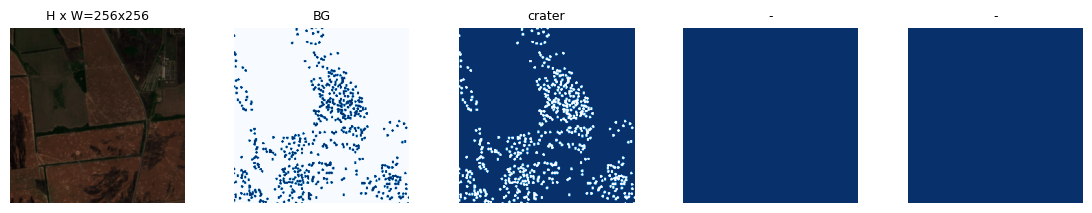

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 4)


for image_id in image_ids:

    image = dataset_train.load_image(image_id)

    mask, class_ids = dataset_train.load_mask(image_id)

    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(
        COCO_MODEL_PATH,
        by_name=True,
        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"],
    )
elif init_with == "last":
    # Load the last model you trained and continue training
    latest = model.find_last()
    print("Loading weights from ", latest)
    model.load_weights(latest, by_name=True)

In [10]:
import warnings

warnings.filterwarnings("ignore")

In [11]:
print("Training network heads")
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers="heads",
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\nochzato\Desktop\thesis\models\mrcnn\logs\craters_25620240427T1603\mask_rcnn_craters_256_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn

In [ ]:
print("Training resnet layers 4+")
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=40,
    layers="4+",
)

In [ ]:
print("Training all layers")
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE / 10,
    epochs=80,
    layers="all",
)

In [ ]:
class InferenceConfig(CraterConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    USE_MINI_MASK = False


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", config=inference_config, model_dir=MODEL_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, inference_config, image_id
)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image,
    gt_bbox,
    gt_mask,
    gt_class_id,
    dataset_train.class_names,
    figsize=(8, 8),
    show_bbox=False,
    colors=[(0, 1, 0), (1, 0, 0)],
)

In [ ]:
results = model.detect([original_image], verbose=1)


r = results[0]
visualize.display_instances(
    original_image,
    r["rois"],
    r["masks"],
    r["class_ids"],
    dataset_val.class_names,
    r["scores"],
    ax=get_ax(),
)

In [ ]:
image_id = np.random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, inference_config, image_id
)
info = dataset_val.image_info[image_id]
print(
    "image ID: {}.{} ({}) {}".format(
        info["source"], info["id"], image_id, dataset_val.image_reference(image_id)
    )
)
print(
    "Original image shape: ",
    modellib.parse_image_meta(image_meta[np.newaxis, ...])["original_image_shape"][0],
)

# Run object detection
results = model.detect_molded(
    np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1
)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(
    gt_bbox,
    gt_class_id,
    gt_mask,
    r["rois"],
    r["class_ids"],
    r["scores"],
    r["masks"],
    verbose=1,
)

visualize.display_differences(
    image,
    gt_bbox,
    gt_class_id,
    gt_mask,
    r["rois"],
    r["class_ids"],
    r["scores"],
    r["masks"],
    dataset_val.class_names,
    ax=get_ax(),
    show_box=False,
    show_mask=False,
    iou_threshold=0.5,
    score_threshold=0.5,
)

In [ ]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    ARs = list()
    F1_scores = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
            dataset, cfg, image_id, use_mini_mask=False
        )
        scaled_image = modellib.mold_image(image, cfg)
        sample = np.expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(
            gt_bbox,
            gt_class_id,
            gt_mask,
            r["rois"],
            r["class_ids"],
            r["scores"],
            r["masks"],
        )
        AR, positive_ids = utils.compute_recall(r["rois"], gt_bbox, iou=0.2)
        ARs.append(AR)
        F1_scores.append(
            (2 * (np.mean(precisions) * np.mean(recalls)))
            / (np.mean(precisions) + np.mean(recalls))
        )
        APs.append(AP)

    mAP = np.mean(APs)
    mAR = np.mean(ARs)
    return mAP, mAR, F1_scores


mAP, mAR, F1_score = evaluate_model(dataset_val, model, inference_config)
print("mAP: %.2f" % (mAP * 100))
print("mAR: %.2f" % (mAR * 100))

F1_score_2 = (2 * mAP * mAR) / (mAP + mAR)
print("F1-score : ", F1_score_2)